In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from norse.torch.functional import (
    lif_step,
    lift,
    lif_feed_forward_step,
    lif_current_encoder,
    LIFParameters,
)

N = 1  # number of neurons to consider
T = 100  # number of timesteps to integrate

p = LIFParameters()
v = torch.zeros(N)  # initial membrane voltage
input_current = 1.1 * torch.ones(N)

voltages = []

for ts in range(T):
    z, v = lif_current_encoder(input_current, v, p)
    voltages.append(v)

voltages = torch.stack(voltages)

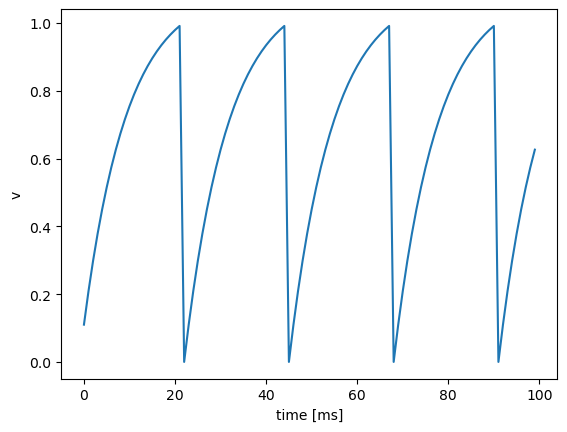

In [3]:
plt.ylabel("v")
plt.xlabel("time [ms]")
plt.plot(voltages)

In [4]:
import torchvision

BATCH_SIZE = 256

transform = torchvision.transforms.Compose(
    [
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.1307,), (0.3081,)),
    ]
)

train_data = torchvision.datasets.MNIST(
    root="./MNIST",
    train=True,
    download=True,
    transform=transform,
)

train_loader = torch.utils.data.DataLoader(
    train_data, batch_size=BATCH_SIZE, shuffle=True
)

test_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST(
        root="./MNIST",
        train=False,
        transform=transform,
    ),
    batch_size=BATCH_SIZE,
)

/Users/chanel/miniconda3/envs/pygame-env/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/Users/chanel/miniconda3/envs/pygame-env/lib/python3.10/site-packages/torchvision/image.so, 0x0006): symbol not found in flat namespace '__ZN3c106detail19maybe_wrap_dim_slowExxb'
  warn(f"Failed to load image Python extension: {e}")


0


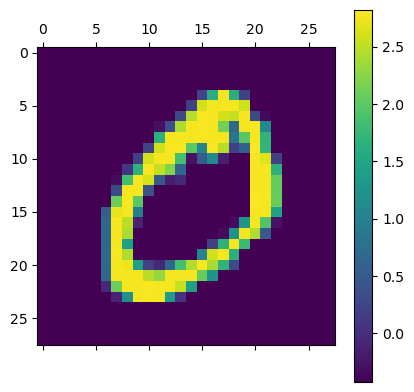

In [5]:
from norse.torch import ConstantCurrentLIFEncoder

img, label = train_data[1]

plt.matshow(img[0])
plt.colorbar()
print(label)

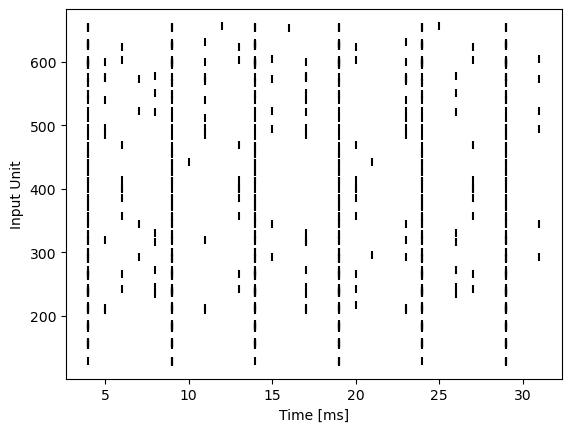

In [6]:
T = 32
example_encoder = ConstantCurrentLIFEncoder(T)


example_input = example_encoder(img)
example_spikes = example_input.reshape(T, 28 * 28).to_sparse().coalesce()
t = example_spikes.indices()[0]
n = example_spikes.indices()[1]

plt.scatter(t, n, marker="|", color="black")
plt.ylabel("Input Unit")
plt.xlabel("Time [ms]")
plt.show()

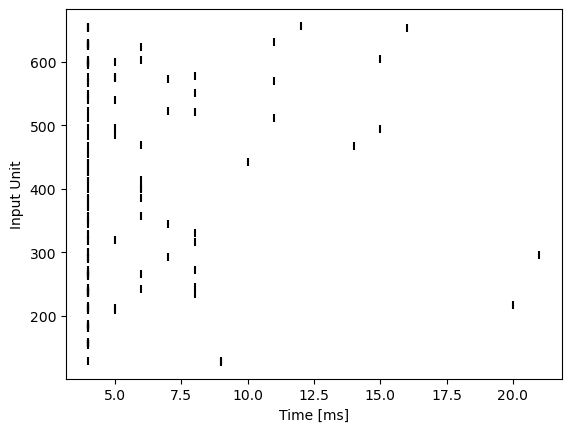

In [7]:
from norse.torch import SpikeLatencyLIFEncoder

T = 32
example_encoder = SpikeLatencyLIFEncoder(T)


example_input = example_encoder(img)
example_spikes = example_input.reshape(T, 28 * 28).to_sparse().coalesce()
t = example_spikes.indices()[0]
n = example_spikes.indices()[1]

plt.scatter(t, n, marker="|", color="black")
plt.ylabel("Input Unit")
plt.xlabel("Time [ms]")
plt.show()

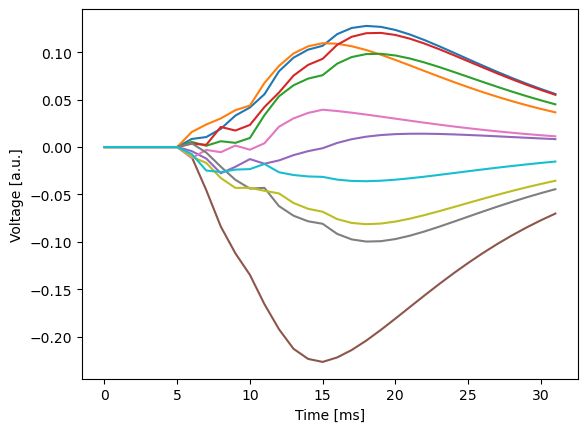

In [8]:
from snn import SNN

example_snn = SNN(28 * 28, 100, 10, record=True, dt=0.001)

example_readout_voltages = example_snn(example_input.unsqueeze(1))
voltages = example_readout_voltages.squeeze(1).detach().numpy()

plt.plot(voltages)
plt.ylabel("Voltage [a.u.]")
plt.xlabel("Time [ms]")
plt.show()

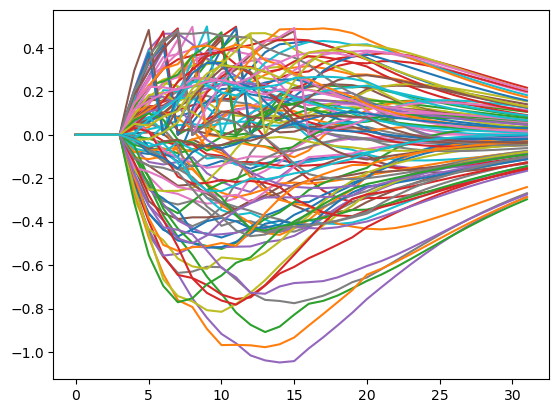

In [9]:
plt.plot(example_snn.recording.lif0.v.squeeze(1).detach().numpy())
plt.show()

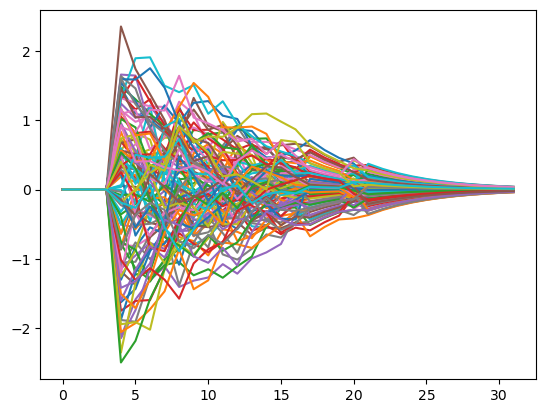

In [10]:
plt.plot(example_snn.recording.lif0.i.squeeze(1).detach().numpy())
plt.show()

In [15]:
from snn import SpikingModel

T = 32
LR = 0.002
INPUT_FEATURES = 28 * 28
HIDDEN_FEATURES = 100
OUTPUT_FEATURES = 10
EPOCHS = 5

if torch.cuda.is_available():
    DEVICE = torch.device("cuda")
else:
    DEVICE = torch.device("cpu")

model = SpikingModel(
    encoder=ConstantCurrentLIFEncoder(
        seq_length=T,
    ),
    snn=SNN(
        num_inputs=INPUT_FEATURES,
        num_hidden=HIDDEN_FEATURES,
        num_outputs=OUTPUT_FEATURES,
    ),
    decode_last=False
).to(DEVICE)

optimizer = torch.optim.Adam(model.parameters(), lr=LR)
model

SpikingModel(
  (snn): SNN(
    (layer1): LIFRecurrentCell(input_size=784, hidden_size=100, p=LIFParameters(tau_syn_inv=tensor(200.), tau_mem_inv=tensor(100.), v_leak=tensor(0.), v_th=tensor(0.5000), v_reset=tensor(0.), method='super', alpha=tensor(50)), autapses=False, dt=0.001)
    (output_layer): Linear(in_features=100, out_features=10, bias=False)
    (output_leaky): LICell(p=LIParameters(tau_syn_inv=tensor(200.), tau_mem_inv=tensor(100.), v_leak=tensor(0.)), dt=0.001)
  )
  (encoder): ConstantCurrentLIFEncoder()
)

In [16]:
from snn import finetune_model, train_model, test_model

training_losses = []
mean_losses = []
test_losses = []
accuracies = []

torch.autograd.set_detect_anomaly(True)

training_loss, mean_loss = train_model(
    model, DEVICE, optimizer, torch.nn.functional.nll_loss, EPOCHS, train_loader, test_loader
)
test_loss, accuracy = test_model(model, DEVICE, test_loader)
training_losses += training_loss
mean_losses.append(mean_loss)
test_losses.append(test_loss)
accuracies.append(accuracy)

print(f"final accuracy: {accuracies[-1]}")

Train epoch 1/5 loss: 0.5501


100%|██████████| 40/40 [00:11<00:00,  3.45it/s]


Test loss: 0.2479
Validation accuracy: 92.30%


Train epoch 2/5 loss: 0.3819


100%|██████████| 40/40 [00:10<00:00,  3.81it/s]


Test loss: 0.1910
Validation accuracy: 93.94%


  4%|▍         | 9/235 [00:05<02:08,  1.76it/s]/Users/chanel/miniconda3/envs/pygame-env/lib/python3.10/site-packages/torch/autograd/__init__.py:200: UserWarning: Error detected in SuperSpikeBackward. Traceback of forward call that caused the error:
  File "/Users/chanel/miniconda3/envs/pygame-env/lib/python3.10/runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/Users/chanel/miniconda3/envs/pygame-env/lib/python3.10/runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "/Users/chanel/miniconda3/envs/pygame-env/lib/python3.10/site-packages/ipykernel_launcher.py", line 17, in <module>
    app.launch_new_instance()
  File "/Users/chanel/miniconda3/envs/pygame-env/lib/python3.10/site-packages/traitlets/config/application.py", line 1043, in launch_instance
    app.start()
  File "/Users/chanel/miniconda3/envs/pygame-env/lib/python3.10/site-packages/ipykernel/kernelapp.py", line 725, in start
    self.io_loop.start()
  File "/User

KeyboardInterrupt: 